# Install the requirments for ENV setup

In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.1 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install -qqq llava-torch==1.1.1 --progress-bar off
# !pip install gdown

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llava-torch 1.1.1 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llava-torch 1.1.1 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
llava-torch 1.1.1 requires transformers==4.31.0, but you have transformers 4.34.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llava-torch 1.1.1 requires accelerate==0.21.0, but you have accelerate 0.23.0 which is incompatible.
l

# load the lib and modules required for test run of LLMs

In [2]:
import textwrap
from io import BytesIO

import requests
import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image
import matplotlib.pyplot as plt

[2025-06-04 16:40:37,068] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-06-04 16:40:39.209719: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-04 16:40:39.209780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-04 16:40:39.213960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
disable_torch_init()
MODEL = "microsoft/llava-med-v1.5-mistral-7b"
model_name = get_model_name_from_path(MODEL)
model_name

'llava-med-v1.5-mistral-7b'

# Load the test images for testing the model

In [4]:
"""!gdown 1mp5rAo4-apdl0DJO5XXQhjMa2ja7IFEH
!gdown 1Qnutc8S7F6jMN6RkJZBgiAePymDcJ3Ii
!gdown 1XM7QgiuNj7KjapaEfjyfxMVWSdQaqsaH
!gdown 1m9v8EVZ16sYcUlCGUH8PFuLxFxaml90U
!gdown 1x7XtPRG-IbSxyCO-ZTo_P7jirwRFY-JN"""

'!gdown 1mp5rAo4-apdl0DJO5XXQhjMa2ja7IFEH\n!gdown 1Qnutc8S7F6jMN6RkJZBgiAePymDcJ3Ii\n!gdown 1XM7QgiuNj7KjapaEfjyfxMVWSdQaqsaH\n!gdown 1m9v8EVZ16sYcUlCGUH8PFuLxFxaml90U\n!gdown 1x7XtPRG-IbSxyCO-ZTo_P7jirwRFY-JN'

In [5]:
tokenizer, model, image_processor, context_len = load_pretrained_model(
                                                    model_path=MODEL, 
                                                    model_base=None, 
                                                    model_name=model_name, 
                                                    load_8bit=False )

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
You are using a model of type llava_mistral to instantiate a model of type llava. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at microsoft/llava-med-v1.5-mistral-7b and are newly initialized: ['model.layers.31.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.23.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.24.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.26.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.inv_freq', 'model.layers.27.self_attn.rotary_emb.inv_freq', 'model.layers.25.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.30.s

In [6]:
def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

In [7]:
def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

In [8]:
def create_prompt(prompt: str):
    CONV_MODE = 'llava_v0'
    conv = conv_templates[CONV_MODE].copy()
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

In [9]:
def ask_image(image: Image, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

In [10]:
%%time
image = load_image("/kaggle/input/vqarad/VQA_RAD Image Folder/synpic100132.jpg");
result = ask_image(image, "Do you know TIRADS_System?")
print(textwrap.fill(result, width=110))

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


Yes, I am familiar with the TIRADS_System. It is a standardized system used to assess and classify thyroid
nodules based on their ultrasound characteristics.
CPU times: user 3.74 s, sys: 248 ms, total: 3.99 s
Wall time: 4.34 s


In [11]:
# Load the saved dataset
data = torch.load('/kaggle/input/peft-thyroid-dataset/augmented_dataset.pt', weights_only=False)

# Print sizes
print("Train images:", data['train_images'].shape)
print("Train labels:", len(data['train_labels']))
print("Train IDs:", len(data['train_ids']))  # list of strings

print("Val images:", data['val_images'].shape)
print("Val labels:", len(data['val_labels']))
print("Val IDs:", len(data['val_ids']))

print("Test images:", data['test_images'].shape)
print("Test labels:", len(data['test_labels']))
print("Test IDs:", len(data['test_ids']))

Train images: torch.Size([1035, 3, 360, 560])
Train labels: 1035
Train IDs: 1035
Val images: (45, 3, 360, 560)
Val labels: 45
Val IDs: 45
Test images: (45, 3, 360, 560)
Test labels: 45
Test IDs: 45


In [12]:
import numpy as np
data = np.load('/kaggle/input/peft-thyroid-dataset/thyroid_images_and_labels.npz')
images = data["images"]
labels = data["labels"]
patient_ids = data["patient_ids"]


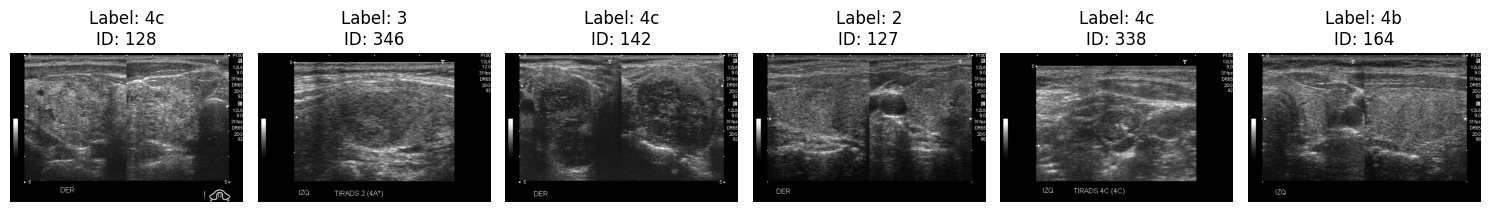

dict_items([('TI-RADS 2', 31.22607421875), ('TI-RADS 3', 31.64013671875), ('TI-RADS 4', 31.63232421875), ('TI-RADS 5', 31.22509765625)])
PatientId: 128, Label:4c, Predicted: TI-RADS 3
dict_items([('TI-RADS 2', 33.5130615234375), ('TI-RADS 3', 33.0130615234375), ('TI-RADS 4', 32.8900146484375), ('TI-RADS 5', 32.1527099609375)])
PatientId: 346, Label:3, Predicted: TI-RADS 2
dict_items([('TI-RADS 2', 33.109375), ('TI-RADS 3', 33.537109375), ('TI-RADS 4', 33.521484375), ('TI-RADS 5', 33.169921875)])
PatientId: 142, Label:4c, Predicted: TI-RADS 3
dict_items([('TI-RADS 2', 32.5146484375), ('TI-RADS 3', 33.0439453125), ('TI-RADS 4', 33.0146484375), ('TI-RADS 5', 32.5478515625)])
PatientId: 127, Label:2, Predicted: TI-RADS 3
dict_items([('TI-RADS 2', 32.04840087890625), ('TI-RADS 3', 33.17926025390625), ('TI-RADS 4', 34.06207275390625), ('TI-RADS 5', 32.32086181640625)])
PatientId: 338, Label:4c, Predicted: TI-RADS 4
dict_items([('TI-RADS 2', 32.5576171875), ('TI-RADS 3', 33.0419921875), ('TI-

In [31]:
def classify_image_by_logits(image: Image, class_labels: list[str], prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    
    input_ids = tokenizer_image_token(
        prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
    ).unsqueeze(0).to(model.device)

    with torch.inference_mode():
        outputs = model(
            input_ids=input_ids,
            images=image_tensor,
            return_dict=True
        )

    # Get the logits for the next token prediction (only last token in prompt)
    next_token_logits = outputs.logits[0, -1]  # shape: [vocab_size]

    # Get scores for each label
    label_scores = {}
    for label in class_labels:
        token_ids = tokenizer(label, add_special_tokens=False)["input_ids"]
        score = sum([next_token_logits[token_id].item() for token_id in token_ids])
        label_scores[label] = score

    print(label_scores.items())
    # Return label with max logit
    return max(label_scores.items(), key=lambda x: x[1])[0]


# Plot the first 5 images
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}\nID: {patient_ids[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

custom_prompt = "The TI-RADS classification of the thyroid ultrasound image is: "
class_labels = ["TI-RADS 2", "TI-RADS 3", "TI-RADS 4", "TI-RADS 5"]

# 
# pred
for i in range(20):
    label = labels[i]
    img_tensor = images[i,:,:]  # shape: (3, 360, 560)
    img_pil = Image.fromarray(img_tensor)
    # Normalize to [0, 1]
    # img_tensor = img_tensor / 255.0

    # logit based classification
    pred = classify_image_by_logits(img_pil, class_labels, custom_prompt)
    # pred = ask_image(img_pil, custom_prompt)
    print(f"PatientId: {patient_ids[i]}, Label:{label}, Predicted: {pred}")

In [34]:
# Load the saved dataset
data = torch.load('/kaggle/input/peft-thyroid-dataset/augmented_dataset.pt', weights_only=False)

# Print sizes
print("Train images:", data['train_images'].shape)
print("Train labels:", len(data['train_labels']))
print("Train IDs:", len(data['train_ids']))  # list of strings

print("Val images:", data['val_images'].shape)
print("Val labels:", len(data['val_labels']))
print("Val IDs:", len(data['val_ids']))

print("Test images:", data['test_images'].shape)
print("Test labels:", len(data['test_labels']))
print("Test IDs:", len(data['test_ids']))

Train images: torch.Size([1035, 3, 360, 560])
Train labels: 1035
Train IDs: 1035
Val images: (45, 3, 360, 560)
Val labels: 45
Val IDs: 45
Test images: (45, 3, 360, 560)
Test labels: 45
Test IDs: 45


In [45]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, balanced_accuracy_score, matthews_corrcoef
)


In [65]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, confusion_matrix,
    classification_report
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, average_precision_score

def get_report(gt_labels, predicted_labels, all_probs, report_name):
    print("Report:", report_name)
    true_labels = gt_labels
    pred_labels = predicted_labels
    # Optional: sort class labels explicitly
    classes = sorted(set(true_labels + pred_labels))  # [2, 3, 4]
    
    # Binarize true labels
    y_true_bin = label_binarize(gt_labels, classes=class_labels)
    y_prob = np.array(all_probs)
    
    # Compute metrics
    roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro')
    pr_auc = average_precision_score(y_true_bin, y_prob, average='macro')
    
    # Compute standard multi-class metrics
    metrics = {
        "Accuracy": accuracy_score(true_labels, pred_labels),
        "Macro Precision": precision_score(true_labels, pred_labels, average='macro', zero_division=0),
        "Macro Recall": recall_score(true_labels, pred_labels, average='macro', zero_division=0),
        "Macro F1 Score": f1_score(true_labels, pred_labels, average='macro', zero_division=0),
        "Weighted F1 Score": f1_score(true_labels, pred_labels, average='weighted', zero_division=0),
        "Balanced Accuracy": balanced_accuracy_score(true_labels, pred_labels),
        "Matthews Correlation Coefficient": matthews_corrcoef(true_labels, pred_labels),
        "AUC-ROC (macro)": roc_auc,
        "AUC-PR (macro": pr_auc
    }
    
    # Display metrics summary table
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
    print("=== Multi-class Summary Metrics ===")
    print(metrics_df.round(4))
    
    # Optional: show full classification report
    print("\n=== Per-class Report ===")
    print(classification_report(true_labels, pred_labels, digits=4))
    print("\n========================")



Report: Baseline Test Data Report
=== Multi-class Summary Metrics ===
                                   Score
Accuracy                          0.3333
Macro Precision                   0.4342
Macro Recall                      0.1719
Macro F1 Score                    0.2373
Weighted F1 Score                 0.4260
Balanced Accuracy                 0.1719
Matthews Correlation Coefficient -0.0378
AUC-ROC (macro)                   0.5007
AUC-PR (macro                     0.3467

=== Per-class Report ===
              precision    recall  f1-score   support

   TI-RADS 2     0.0000    0.0000    0.0000         5
   TI-RADS 3     0.0000    0.0000    0.0000         4
   TI-RADS 4     0.7368    0.4375    0.5490        32
   TI-RADS 5     1.0000    0.2500    0.4000         4

    accuracy                         0.3333        45
   macro avg     0.4342    0.1719    0.2373        45
weighted avg     0.6129    0.3333    0.4260        45




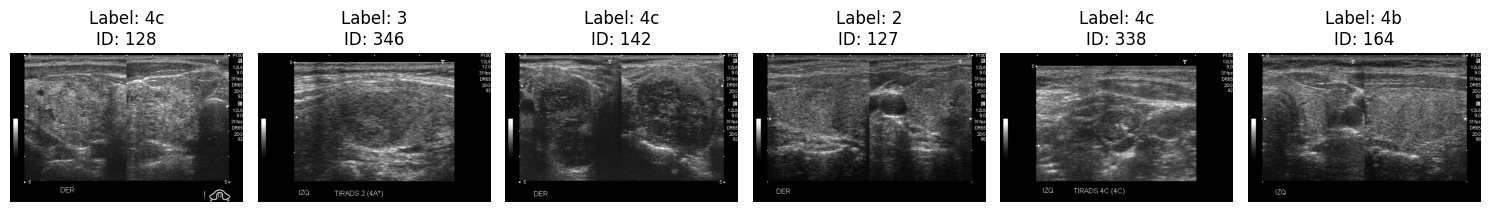

45
PatientId: 259, Label:TI-RADS 3, Predicted: TI-RADS 2
PatientId: 18, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 91, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 79, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 311, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 32, Label:TI-RADS 2, Predicted: TI-RADS 3
PatientId: 198, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 176, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 83, Label:TI-RADS 5, Predicted: TI-RADS 5
PatientId: 346, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 204, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 20, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 129, Label:TI-RADS 3, Predicted: TI-RADS 2
PatientId: 110, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 22, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 105, Label:TI-RADS 3, Predicted: TI-RADS 4
PatientId: 53, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 12, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 269, Label:TI-RADS 4, P

In [56]:
import torch.nn.functional as F

def classify_image_by_logits(image: Image, class_labels: list[str], prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    
    input_ids = tokenizer_image_token(
        prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
    ).unsqueeze(0).to(model.device)

    with torch.inference_mode():
        outputs = model(
            input_ids=input_ids,
            images=image_tensor,
            return_dict=True
        )

    # Get the logits for the next token prediction (only last token in prompt)
    next_token_logits = outputs.logits[0, -1]  # shape: [vocab_size]

    # Compute logits for all class labels
    label_scores = []
    for label in class_labels:
        token_ids = tokenizer(label, add_special_tokens=False)["input_ids"]
        logit_sum = sum([next_token_logits[token_id].item() for token_id in token_ids])
        label_scores.append(logit_sum)

    # Convert logits to probabilities
    label_scores_tensor = torch.tensor(label_scores)
    softmax_probs = F.softmax(label_scores_tensor, dim=0).tolist()

    # Get predicted label
    best_index = int(torch.argmax(label_scores_tensor))
    predicted_label = class_labels[best_index]

    return predicted_label, softmax_probs


# Plot the first 5 images
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}\nID: {patient_ids[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

def map_label_to_tirads(label):
    if "2" in label: return "TI-RADS 2"
    elif "3" in label: return "TI-RADS 3"
    elif "4" in label: return "TI-RADS 4"
    elif "5" in label: return "TI-RADS 5"
    else: return "Unknown"
    
custom_prompt = "The TI-RADS classification of the thyroid ultrasound image is: "
class_labels = ["TI-RADS 2", "TI-RADS 3", "TI-RADS 4", "TI-RADS 5"]

print(len(data['test_labels']))
gt_labels = []
predicted_labels = []
all_probs = []
for i in range(len(data['test_labels'])):
    img_tensor = data['test_images'][i]  # shape: (3, 360, 560)

    gt_label = map_label_to_tirads(data['test_labels'][i])
    gt_labels.append(gt_label)

    pred, probs = classify_image_by_logits(img_tensor, class_labels, custom_prompt)
    predicted_labels.append(pred)

    all_probs.append(probs)
    print(f"PatientId: {data['test_ids'][i]}, Label:{gt_label}, Predicted: {pred}")

baseline_report = get_report(gt_labels, predicted_labels, all_probs, "Baseline Test Data Report")

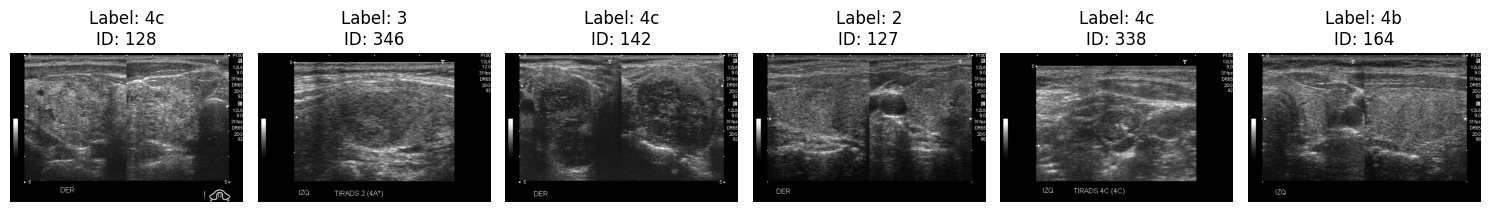

45
PatientId: 233, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 76, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 30, Label:TI-RADS 5, Predicted: TI-RADS 3
PatientId: 141, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 217, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 11, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 378, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 334, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 74, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 247, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 89, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 192, Label:TI-RADS 2, Predicted: TI-RADS 4
PatientId: 343, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 179, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 220, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 227, Label:TI-RADS 4, Predicted: TI-RADS 4
PatientId: 5, Label:TI-RADS 2, Predicted: TI-RADS 2
PatientId: 335, Label:TI-RADS 4, Predicted: TI-RADS 3
PatientId: 372, Label:TI-RADS 5,

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
# Plot the first 5 images
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}\nID: {patient_ids[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

def map_label_to_tirads(label):
    if "2" in label: return "TI-RADS 2"
    elif "3" in label: return "TI-RADS 3"
    elif "4" in label: return "TI-RADS 4"
    elif "5" in label: return "TI-RADS 5"
    else: return "Unknown"
    
custom_prompt = "The TI-RADS classification of the thyroid ultrasound image is: "
class_labels = ["TI-RADS 2", "TI-RADS 3", "TI-RADS 4", "TI-RADS 5"]

print(len(data['val_labels']))
gt_labels = []
predicted_labels = []
all_probs = []
for i in range(len(data['val_labels'])):
    img_tensor = data['val_images'][i]  # shape: (3, 360, 560)

    gt_label = map_label_to_tirads(data['val_labels'][i])
    gt_labels.append(gt_label)

    pred, probs = classify_image_by_logits(img_tensor, class_labels, custom_prompt)
    predicted_labels.append(pred)

    all_probs.append(probs)
    print(f"PatientId: {data['val_ids'][i]}, Label:{gt_label}, Predicted: {pred}")
baseline_report = get_report(gt_labels, predicted_labels, all_probs, "Baseline Val Data Report")